In [1]:
!pip install pandas numpy scikit-learn lightgbm xgboost matplotlib shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import seaborn as sns
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import re

In [3]:
data_dir = Path(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\home-credit-default-risk")
print((data_dir / "application_train.csv").exists())
print((data_dir / "application_test.csv").exists())

True
True


# Quick EDA

In [4]:
# Đọc dữ liệu
train = pd.read_csv(data_dir / "application_train.csv")
test = pd.read_csv(data_dir / "application_test.csv")
print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()
test.head()

Train shape: (307511, 122)
Test shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# =========================
# 1. Kiểm tra biến TARGET
# =========================
# TARGET là cột nhãn (1 = khách hàng vỡ nợ, 0 = trả nợ bình thường)
# 8% vỡ nợ

print("Phân phối TARGET:")
print(train["TARGET"].value_counts(normalize=True))

plt.figure(figsize=(5,4))
sns.countplot(data=train, x="TARGET")
plt.title("Phân phối TARGET (0 = trả nợ, 1 = vỡ nợ)")
plt.show()

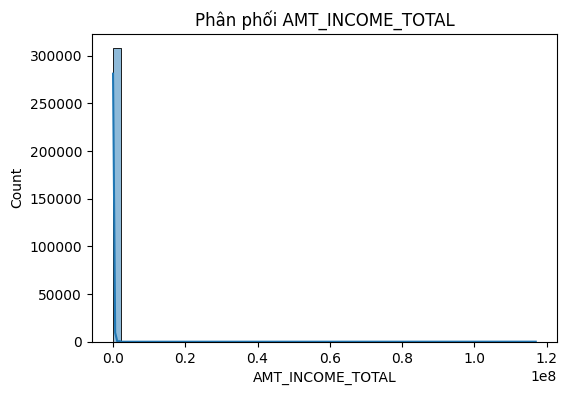

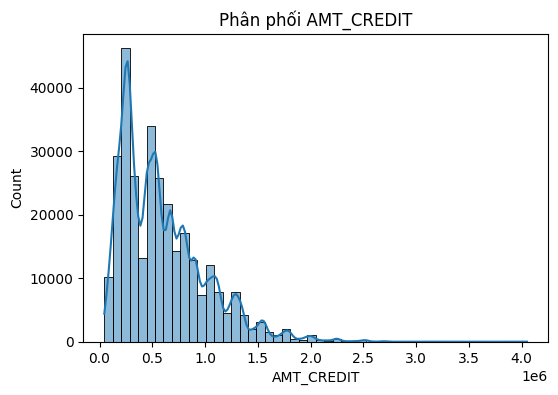

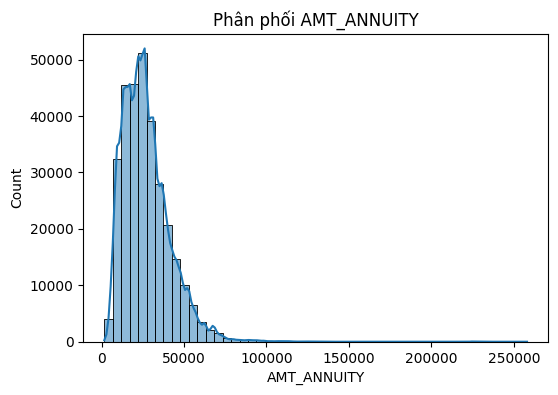

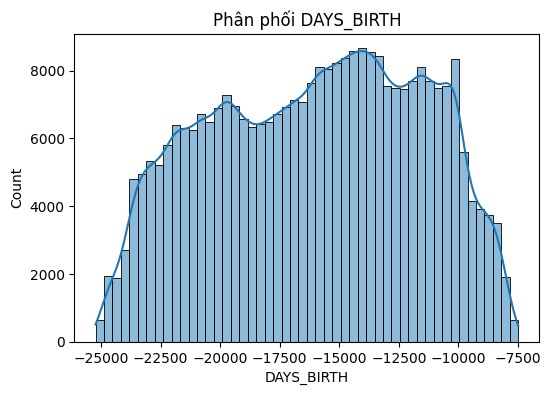

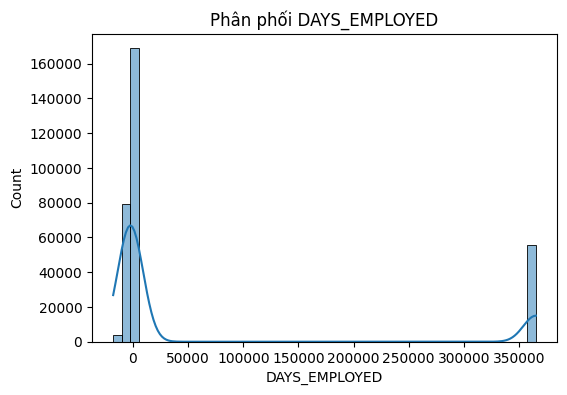

In [24]:
# =========================
# 2. Một số biến số (numerical)
# =========================
num_cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "DAYS_BIRTH", "DAYS_EMPLOYED"]

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f"Phân phối {col}")
    plt.show()

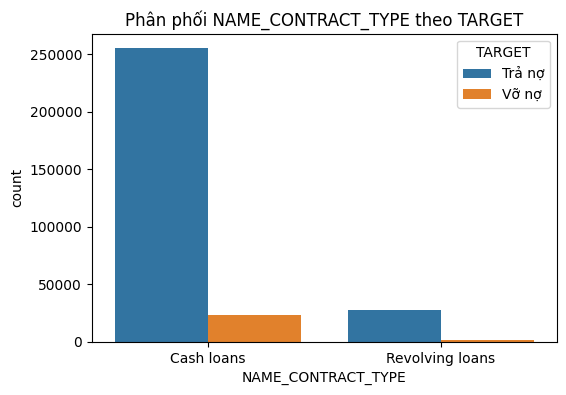

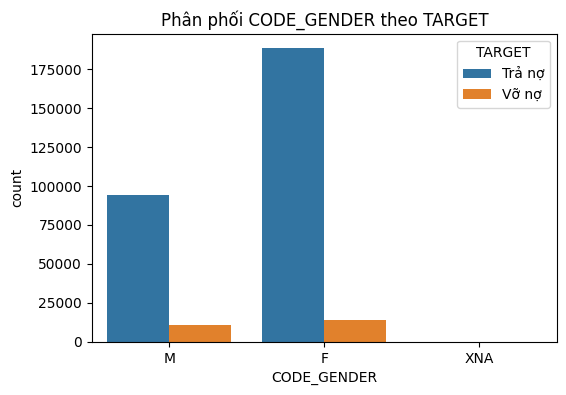

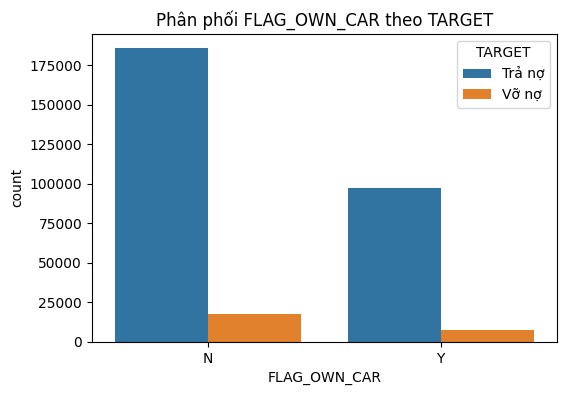

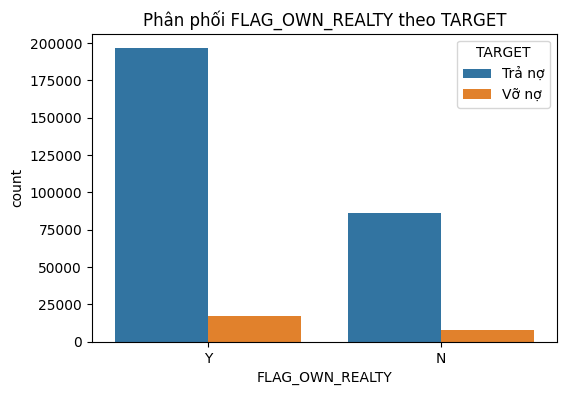

In [25]:
# =========================
# 3. Một số biến phân loại (categorical)
# =========================
cat_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=train, x=col, hue="TARGET")
    plt.title(f"Phân phối {col} theo TARGET")
    plt.legend(title="TARGET", labels=["Trả nợ", "Vỡ nợ"])
    plt.show()

In [ ]:
# =========================
# 4. Quan hệ giữa AGE và TARGET
# =========================
# DAYS_BIRTH là số ngày âm -> chuyển sang tuổi
train["AGE"] = -train["DAYS_BIRTH"] / 365

plt.figure(figsize=(6,4))
sns.histplot(train, x="AGE", hue="TARGET", bins=50, kde=False, element="step", stat="density")
plt.title("Phân phối AGE theo TARGET")
plt.show()

### 📊 Nhận xét biểu đồ:

- Biểu đồ TARGET: rất mất cân bằng (~92% = 0, 8% = 1).

- Income, Credit, Annuity: có outlier (thu nhập cực cao).

- Categorical: ví dụ giới tính (nam/nữ) phân bổ khác nhau theo TARGET.

- Age: khách hàng trẻ tuổi thường có tỷ lệ vỡ nợ cao hơn.

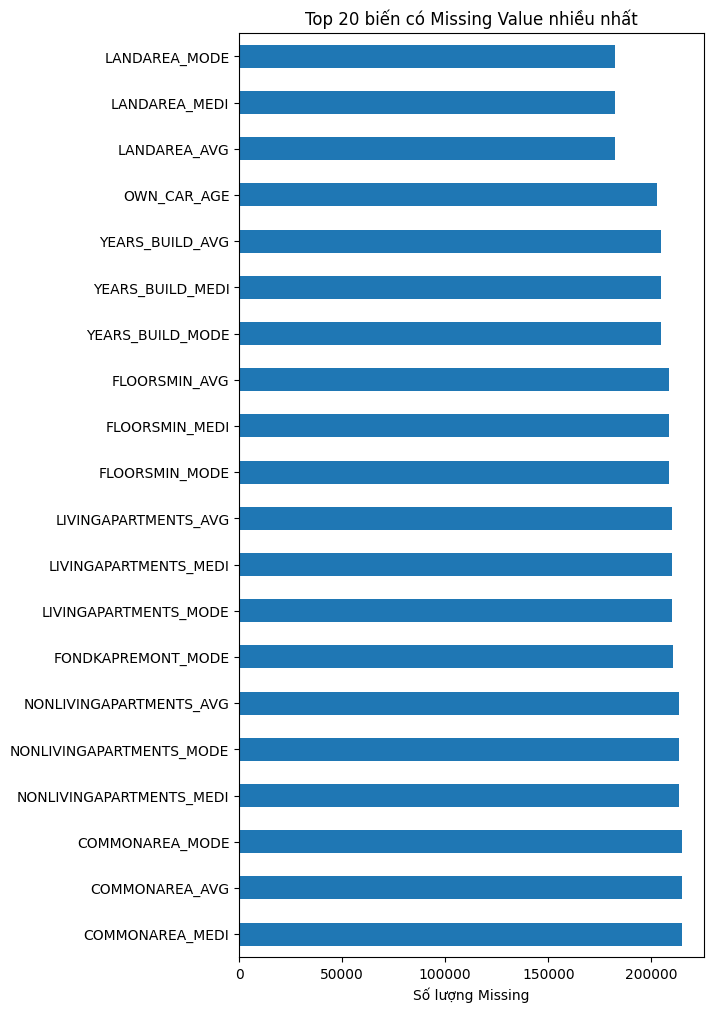

Tỷ lệ missing value cao nhất:
COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_MODE       68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_AVG        68.354953
dtype: float64


In [26]:
# ======================================
# 1. Phân tích Missing Values
# ======================================
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(6,12))
missing[:20].plot(kind="barh")
plt.title("Top 20 biến có Missing Value nhiều nhất")
plt.xlabel("Số lượng Missing")
plt.show()

print("Tỷ lệ missing value cao nhất:")
print((missing / len(train) * 100).head(10))

### 📊 Giải thích kết quả:

- Nhiều cột có missing cực cao (ví dụ OWN_CAR_AGE, OCCUPATION_TYPE, hoặc dữ liệu từ bảng con).

- Bạn cần quyết định:

    - Drop cột nếu missing quá 40–50%.

    - Hoặc điền giá trị trung vị/mean/“Unknown”.

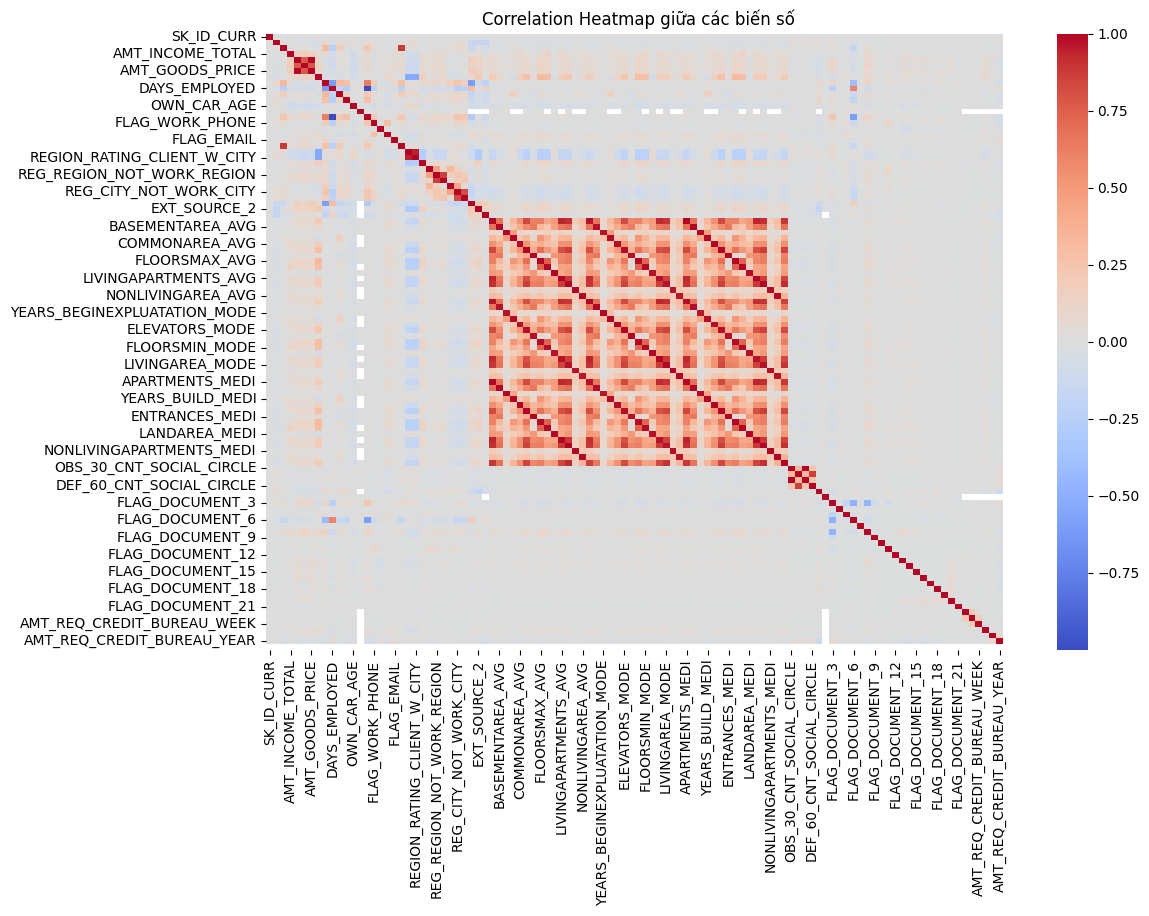

Top 10 biến tương quan mạnh nhất với TARGET:
TARGET                         1.000000
EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
Name: TARGET, dtype: float64


In [27]:
# ======================================
# 2. Correlation Heatmap (biến số)
# ======================================
# Lấy các biến số
numeric_cols = train.select_dtypes(include=["int64","float64"]).columns

# Tính correlation với TARGET
corr = train[numeric_cols].corr()

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap giữa các biến số")
plt.show()

# Xem top 10 biến tương quan mạnh nhất với TARGET
corr_target = corr["TARGET"].sort_values(key=abs, ascending=False)
print("Top 10 biến tương quan mạnh nhất với TARGET:")
print(corr_target.head(11))  # bao gồm cả TARGET=1.0

### 📊 Giải thích kết quả:

- EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 thường có tương quan cao với TARGET → rất quan trọng.

- DAYS_BIRTH (tuổi) cũng thường có tương quan.

- Các biến tiền (AMT_CREDIT, AMT_INCOME_TOTAL) thường tương quan yếu.

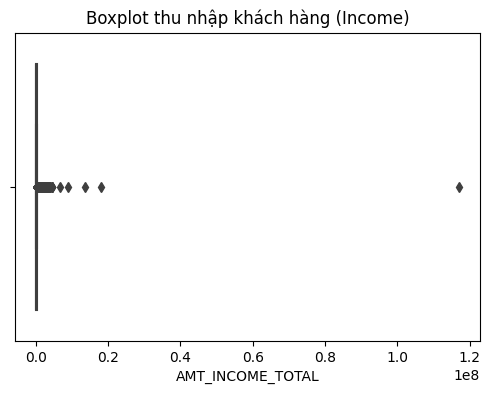

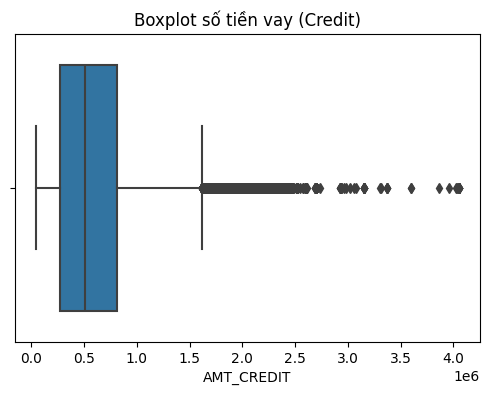

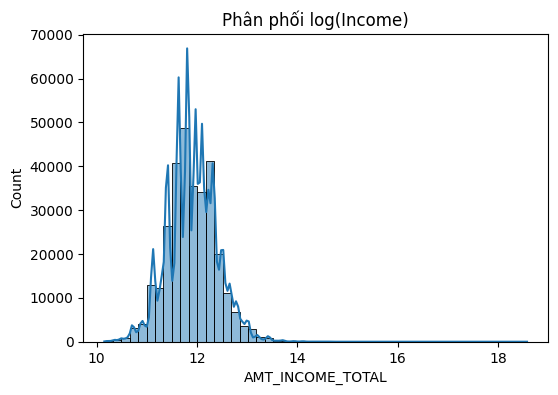

In [28]:
# ======================================
# 3. Phân tích Outliers (ví dụ AMT_INCOME_TOTAL, AMT_CREDIT)
# ======================================
plt.figure(figsize=(6,4))
sns.boxplot(x=train["AMT_INCOME_TOTAL"])
plt.title("Boxplot thu nhập khách hàng (Income)")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=train["AMT_CREDIT"])
plt.title("Boxplot số tiền vay (Credit)")
plt.show()

# Có thể zoom vào bằng cách log-transform để dễ nhìn
import numpy as np
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(train["AMT_INCOME_TOTAL"]), bins=50, kde=True)
plt.title("Phân phối log(Income)")
plt.show()

### 📊 Giải thích kết quả:

- AMT_INCOME_TOTAL có outlier cực lớn (thu nhập hàng trăm triệu USD).

- Nên dùng log-transform để giảm skewness.

- Có thể clip giá trị cực đoan (top 99%).

# Xử lý dữ liệu nền (Application)

In [5]:
# Gộp train + test để one-hot encode cho đồng nhất.
# One-hot encode các cột phân loại (object).
# Giữ lại TARGET riêng ra.
# Giữ lại TARGET
y = train["TARGET"].reset_index(drop=True).copy()

# Đánh dấu train/test
train["is_train"] = 1
test["is_train"] = 0

# Bỏ cột TARGET khỏi train để nối vào test
train_ = train.drop(columns=["TARGET"]).reset_index(drop=True)
test = test.reset_index(drop=True)
app = pd.concat([train_, test], axis=0, ignore_index=True)

print("App shape before OHE:", app.shape)

# One-hot encode các cột phân loại
app = pd.get_dummies(app, dummy_na=True)
print("App shape after OHE:", app.shape)

# Tách lại train/test
app_train = app[app["is_train"] == 1].drop(columns=["is_train"]).reset_index(drop=True)
app_test  = app[app["is_train"] == 0].drop(columns=["is_train"]).reset_index(drop=True)
print("Final train:", app_train.shape, " test:", app_test.shape)

App shape before OHE: (356255, 122)
App shape after OHE: (356255, 262)
Final train: (307511, 261)  test: (48744, 261)


# Feature engineering theo khách hàng (SK_ID_CURR)

In [6]:
# bureau_balance.csv: Lịch sử tín dụng chi tiết hàng tháng cho từng khoản vay (status = đúng hạn, trễ hạn, đóng, …)
# Đọc dữ liệu bureau_balance
bb = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\bureau_balance.csv")
print("Bureau Balance shape:", bb.shape)
print(bb.head())

# One-hot encode cột STATUS
bb = pd.get_dummies(bb, columns=["STATUS"], dummy_na=True)

# Gộp theo SK_ID_BUREAU
bb_agg = bb.groupby("SK_ID_BUREAU").agg(["min","max","mean","sum","size"])
bb_agg.columns = ["BB_" + "_".join(col).strip() for col in bb_agg.columns.values]

print("Bureau Balance agg shape:", bb_agg.shape)
# print(bb_agg.head())

# Đọc bureau.csv
bureau = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\bureau.csv")

# Merge vào bureau
bureau = bureau.merge(bb_agg, how="left", on="SK_ID_BUREAU")
print("Bureau shape after merge:", bureau.shape)

Bureau Balance shape: (27299925, 3)
   SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C
Bureau Balance agg shape: (817395, 50)
Bureau shape after merge: (1716428, 67)


### 🔹 Ý nghĩa feature mới

- BB_MONTHS_BALANCE_MIN: số tháng lâu nhất mà có record cho khoản vay (ví dụ -60 = 5 năm trước).

- BB_STATUS_0_SUM: tổng số tháng khoản vay trả đúng hạn.

- BB_STATUS_1_SUM: tổng số tháng trễ hạn 1–30 ngày.

- BB_STATUS_5_SUM: tổng số tháng nợ xấu >180 ngày.

- BB_STATUS_C_SUM: số tháng khoản vay đã đóng.

### 👉 Các feature này phản ánh lịch sử tín dụng chi tiết → cực kỳ quan trọng để dự đoán rủi ro.

In [7]:
# bureau.csv: chứa thông tin các khoản vay trước đây của khách hàng tại những tổ chức tín dụng khác.
# One-hot encode bureau (sau khi merge bb)
bureau = pd.get_dummies(bureau, dummy_na=True)

# Group theo SK_ID_CURR
bureau_agg = bureau.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])

# Đặt tên lại cột
bureau_agg.columns = ["BUREAU_" + "_".join(col).strip() for col in bureau_agg.columns.values]

print("Bureau agg shape:", bureau_agg.shape)

# Merge vào app_train và app_test
app_train = app_train.merge(bureau_agg, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(bureau_agg, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

Bureau agg shape: (305811, 445)
App train: (307511, 706)  App test: (48744, 706)


### 🔹 Ý nghĩa feature mới

Ví dụ vài cột sau khi aggregate:

BUREAU_AMT_CREDIT_SUM_DEBT_MEAN: trung bình số nợ còn lại của khách hàng tại các khoản vay bên ngoài.

BUREAU_DAYS_CREDIT_MIN: khoản vay xa nhất trong quá khứ (tính theo ngày).

BUREAU_CREDIT_ACTIVE_Active_SUM: số khoản vay đang hoạt động.

BUREAU_BB_STATUS_5_SUM: tổng số tháng bị nợ xấu (lấy từ bureau_balance).

👉 Nhờ các feature này, model biết khách hàng vay ở nơi khác có lịch sử tốt hay xấu.

In [ ]:
# previous_application.csv: toàn bộ các đơn vay trước đây của khách hàng tại Home Credit.
# Load dữ liệu
previous = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\previous_application.csv")
print("Previous shape:", previous.shape)
print(previous[["SK_ID_CURR","SK_ID_PREV","NAME_CONTRACT_TYPE","AMT_APPLICATION","AMT_CREDIT","NAME_CONTRACT_STATUS"]].head())

# One-hot encode các biến phân loại
previous = pd.get_dummies(previous, dummy_na=True)

# Group theo SK_ID_CURR
prev_agg = previous.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])
prev_agg.columns = ["PREV_" + "_".join(col).strip() for col in prev_agg.columns.values]

print("Previous agg shape:", prev_agg.shape)

# Merge vào app_train và app_test
app_train = app_train.merge(prev_agg, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(prev_agg, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

🔹 Ý nghĩa feature mới

PREV_AMT_APPLICATION_MEAN: trung bình số tiền khách hàng từng yêu cầu vay.

PREV_NAME_CONTRACT_STATUS_Refused_SUM: số lần bị từ chối.

PREV_NAME_CONTRACT_STATUS_Approved_SUM: số lần được duyệt.

PREV_AMT_CREDIT_MAX: số tiền vay lớn nhất từng được cấp.

👉 Tất cả những cái này giúp model học về lịch sử vay cũ ảnh hưởng tới rủi ro tín dụng hiện tại.

In [ ]:
# installments_payments.csv: Ghi lại lịch sử trả góp của khách hàng cho từng khoản vay trước (SK_ID_PREV)
# Đọc file installments
ins = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\installments_payments.csv")
print("Installments shape:", ins.shape)
print(ins.head())

# Feature mới: ngày trễ hạn (âm = trả sớm, dương = trả trễ)
ins["DAYS_LATE"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]

# Feature mới: chênh lệch tiền trả
ins["AMT_DIFF"] = ins["AMT_PAYMENT"] - ins["AMT_INSTALMENT"]

# Group theo khách hàng
ins_agg = ins.groupby("SK_ID_CURR").agg(["min","max","mean","sum","var"])
ins_agg.columns = ["INS_" + "_".join(col).strip() for col in ins_agg.columns.values]

print("Installments agg shape:", ins_agg.shape)

# Merge vào app
app_train = app_train.merge(ins_agg, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(ins_agg, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

🔹 Ý nghĩa feature mới

INS_DAYS_LATE_MEAN: trung bình số ngày khách hàng trả trễ.

INS_AMT_DIFF_SUM: tổng số tiền trả thừa (dương) hoặc thiếu (âm).

INS_AMT_PAYMENT_MEAN: trung bình số tiền mỗi kỳ khách hàng thực trả.

INS_AMT_INSTALMENT_SUM: tổng số tiền khách hàng đã từng phải trả.

👉 Đây là feature rất quan trọng, vì nó phản ánh thói quen trả nợ thực tế.

In [ ]:
# POS_CASH_balance.csv: Ghi lại lịch sử khoản vay trả góp / thẻ tín dụng trả góp tại điểm bán.
# Đọc file POS_CASH_balance
pos = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\POS_CASH_balance.csv")
print("POS shape:", pos.shape)
print(pos.head())

# OHE cho cột trạng thái hợp đồng
pos = pd.get_dummies(pos, columns=["NAME_CONTRACT_STATUS"], dummy_na=True)

# Group theo SK_ID_PREV (tức là mỗi khoản vay)
pos_agg = pos.groupby("SK_ID_PREV").agg(["min", "max", "mean", "size"])
pos_agg.columns = ["POS_" + "_".join(col).strip() for col in pos_agg.columns.values]

print("POS agg by SK_ID_PREV:", pos_agg.shape)

# Merge vào previous_application để ánh xạ SK_ID_PREV -> SK_ID_CURR
prev = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\previous_application.csv")[["SK_ID_PREV","SK_ID_CURR"]]
pos_merged = pos_agg.merge(prev, on="SK_ID_PREV", how="left")

# Bỏ SK_ID_PREV để chỉ còn SK_ID_CURR
pos_merged = pos_merged.drop(columns=["SK_ID_PREV"])

# Group tiếp theo SK_ID_CURR
pos_final = pos_merged.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
pos_final.columns = ["POS_" + "_".join(col).strip() for col in pos_final.columns.values]

print("POS final agg by SK_ID_CURR:", pos_final.shape)

# Merge vào app
app_train = app_train.merge(pos_final, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(pos_final, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, " App test:", app_test.shape)

🔹 Ý nghĩa feature mới

POS_MONTHS_BALANCE_MIN: số tháng xa nhất khách hàng từng có khoản vay POS (thường là âm lớn → vay từ lâu).

POS_CNT_INSTALMENT_FUTURE_MEAN: trung bình số kỳ trả góp còn lại.

POS_NAME_CONTRACT_STATUS_Completed_MEAN: tỷ lệ khoản vay đã hoàn thành.

POS_NAME_CONTRACT_STATUS_Active_MEAN: tỷ lệ khoản vay còn đang hoạt động.

POS_size: số tháng khách hàng xuất hiện trong POS (kỳ hạn dài hơn = nhiều dòng hơn).

In [ ]:
# credit_card_balance.csv: Dữ liệu cân đối hàng tháng cho từng thẻ tín dụng của khách hàng (không phải khoản vay POS)
# Đọc file credit_card_balance
cc = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\credit_card_balance.csv")
print("Credit card balance shape:", cc.shape)
print(cc.head())

# One-hot encode biến phân loại
cc = pd.get_dummies(cc, columns=["NAME_CONTRACT_STATUS"], dummy_na=True)

# Group theo SK_ID_PREV trước
cc_agg_prev = cc.groupby("SK_ID_PREV").agg([
    "min", "max", "mean", "sum", "var"
])

# Làm phẳng tên cột
cc_agg_prev.columns = ["CC_" + "_".join(col).upper() for col in cc_agg_prev.columns.values]

# Đọc ánh xạ SK_ID_PREV -> SK_ID_CURR
prev_map = pd.read_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Raw Data\previous_application.csv")[["SK_ID_PREV", "SK_ID_CURR"]]

# Gắn SK_ID_CURR vào cc_agg_prev
cc_agg = cc_agg_prev.merge(prev_map, on="SK_ID_PREV", how="left")

# Group lần 2 theo khách hàng
cc_final = cc_agg.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
cc_final.columns = ["CC_" + "_".join(col).upper() for col in cc_final.columns.values]

print("Credit card features shape:", cc_final.shape)

# Merge vào app_train và app_test
app_train = app_train.merge(cc_final, how="left", on="SK_ID_CURR")
app_test  = app_test.merge(cc_final, how="left", on="SK_ID_CURR")

print("App train:", app_train.shape, "App test:", app_test.shape)

# Dọn RAM
del cc, cc_agg_prev, cc_agg, prev_map, cc_final
gc.collect()

🔹 Ý nghĩa feature mới
CC_AMT_BALANCE_MEAN: số dư trung bình trên thẻ.

CC_AMT_CREDIT_LIMIT_ACTUAL_MAX: hạn mức thẻ cao nhất từng có.

CC_AMT_DRAWINGS_CURRENT_SUM: tổng tiền đã rút (tiêu xài).

CC_CNT_DRAWINGS_ATM_CURRENT_MEAN: trung bình số lần rút tiền mặt qua ATM.

CC_NAME_CONTRACT_STATUS_Active_MEAN: tỷ lệ tháng thẻ ở trạng thái Active.

# Machine Learning

## Chuẩn bị dữ liệu

In [14]:
def clean_column_names(df):
    df = df.copy()
    df.columns = [
        re.sub(r'[^A-Za-z0-9_]+', '_', col)  # thay ký tự đặc biệt bằng "_"
        for col in df.columns
    ]
    return df

X_train = clean_column_names(X_train)
X_valid = clean_column_names(X_valid)
X_test  = clean_column_names(X_test)

In [15]:
# Sau khi merge/gộp xong hết
app_train = clean_column_names(app_train)
app_test  = clean_column_names(app_test)

# Lấy nhãn từ file train gốc
labels = train[["SK_ID_CURR", "TARGET"]].set_index("SK_ID_CURR")

# Căn chỉnh y theo đúng thứ tự hàng của app_train
y = labels.loc[app_train["SK_ID_CURR"], "TARGET"].values

# X và X_test KHÔNG drop TARGET nữa (vì không có cột này trong app_train/app_test)
X = app_train.drop(columns=["SK_ID_CURR"])
X_test = app_test.drop(columns=["SK_ID_CURR"])

# Điền missing
X = X.fillna(-999)
X_test = X_test.fillna(-999)

# sanity check
assert len(y) == len(X)

## Baseline model (Logistic Regression)  

In [16]:
# Train/valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic Regression baseline
log_reg = LogisticRegression(max_iter=1000, solver="lbfgs")
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict_proba(X_valid)[:,1]
auc_baseline = roc_auc_score(y_valid, y_pred)

print("Baseline Logistic Regression AUC:", auc_baseline)

Baseline Logistic Regression AUC: 0.5


## Model chính (LightGBM) 

In [17]:
# Tạo Dataset cho LightGBM
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)

# Thông số model
model = LGBMClassifier(
    objective="binary",
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42, 
    #n_estimators=10000
)

# Train với callbacks
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric="auc",
    callbacks=[early_stopping(stopping_rounds=200), log_evaluation(200)]
)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.028240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
               learning_rate=0.05, objective='binary', random_state=42)

##  Cross Validation (K-Fold)

In [18]:
# Khởi tạo KFold
folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Mảng lưu kết quả
oof_preds = np.zeros(len(X))
sub_preds = np.zeros(len(X_test))

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    print(f"\n===== Fold {n_fold+1} =====")
    
    # Tách train/valid theo index
    train_x, train_y = X.iloc[train_idx], y[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y[valid_idx]
    
    # Khởi tạo model
    model = LGBMClassifier(
        objective="binary",
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42,
        #n_estimators=10000   # cần cho early stopping
    )
    
    # Train
    model.fit(
        train_x, train_y,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_metric="auc",
        callbacks=[early_stopping(200), log_evaluation(200)]
    )
    
    # Lưu OOF predictions
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    
    # Lưu test predictions (trung bình qua folds)
    sub_preds += model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits


===== Fold 1 =====
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.413740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59484
[LightGBM] [I

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.368946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59430
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 685
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080977 -> initscore=-2.429150
[LightGBM] [Info] Start training from score -2.429150
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.785058	training's binary_logloss: 0.239427	valid_1's auc: 0.756122	valid_1's binary_logloss

## Feature Importance (LightGBM)

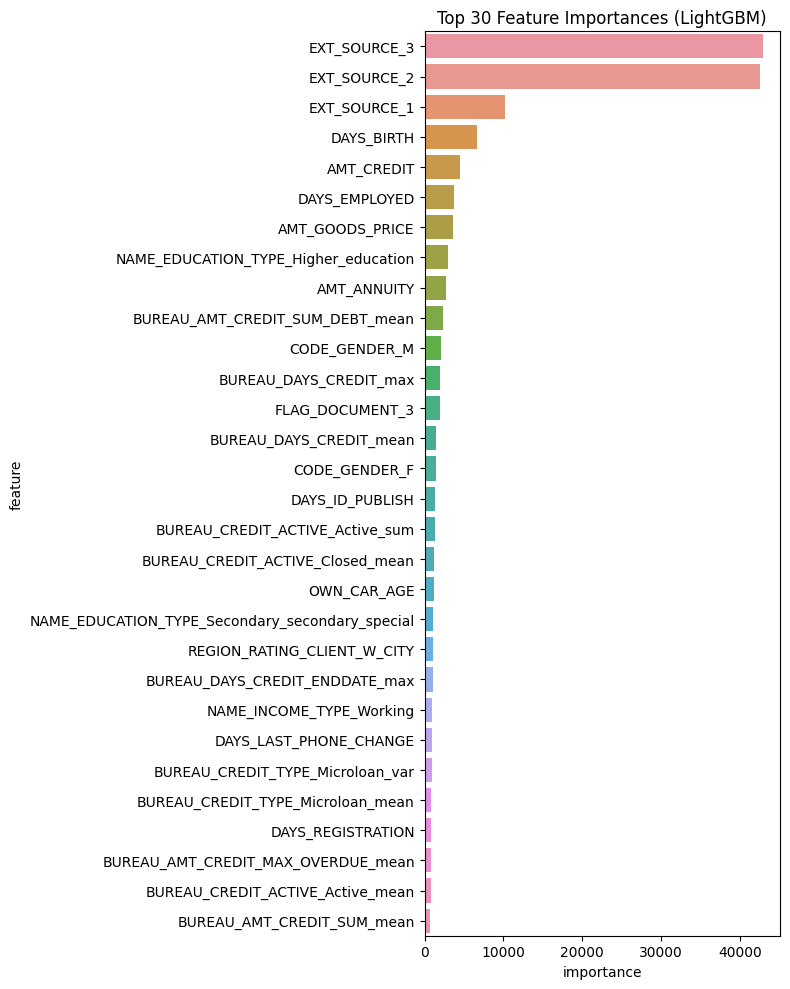

In [20]:
# Sau vòng for KFold, lấy booster từ model cuối cùng
booster = model.booster_

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = booster.feature_name()
feature_importance_df["importance"] = booster.feature_importance(importance_type="gain")

# Top 30 features
top_feats = feature_importance_df.sort_values("importance", ascending=False).head(30)

plt.figure(figsize=(8,10))
sns.barplot(x="importance", y="feature", data=top_feats)
plt.title("Top 30 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

##  Dự đoán trên test + Submission

In [23]:
# Tính AUC trên toàn bộ OOF
cv_auc = roc_auc_score(y, oof_preds)
print(f"CV AUC (OOF): {cv_auc:.6f}")

CV AUC (OOF): 0.757585


In [22]:
submission = app_test[["SK_ID_CURR"]].copy()
submission["TARGET"] = sub_preds
submission.to_csv(r"D:\TRƯỜNG TỰ NHIÊN\DATA ANALYTICS\PROJECT\Home Credit Rick\Output\submission.csv", index=False)